<a href="https://colab.research.google.com/github/Shahriar10k/RAG-with-NSU/blob/main/QA_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import the files from drive**
 Using gdown [https://github.com/wkentaro/gdown]


In [ ]:
import gdown

#Specify the name to be given to the file locally
output= 'test_articles.zip'

#Specify the Google drive ID of the folder
file_id = '1S1fzhVdTaV7Xgk35thav_3IJENOBA0Si'
#Download the file
gdown.download('https://drive.google.com/uc?id='+file_id,output, quiet=False)

print("Completed.....")

Downloading...
From: https://drive.google.com/uc?id=1S1fzhVdTaV7Xgk35thav_3IJENOBA0Si
To: /content/test_articles.zip
100%|██████████| 70.9k/70.9k [00:00<00:00, 12.1MB/s]

Completed.....


Unzip the folder and find articles

In [ ]:
import shutil
shutil.unpack_archive("test_articles.zip", "./")

Read in each of the articles and use the filename as article title

In [ ]:
import os
import urllib

titles = []
articles = []

print('Reading in all articles.....')

i=0

#Read for each of the files in the subdirectory....
for filename in os.listdir("./499Dataset/"):

    #Skip non text files
    if not filename[-3:] == "txt":
      continue

    #Open the file
    with open("499Dataset/"+ filename, "rb") as f:
        # Use the file name as the article title (strip the ".txt")
         titles.append(filename[:-4])

         # Read in the article text.
         articles.append(f.read().decode('utf-8'))

print(' Done.\n')

print(' There are {:,} articles.' .format(len(articles)))

Reading in all articles.....
 Done.

 There are 154 articles.


In [ ]:
print(titles[0])

print("\n...........Context start........")
print("\n"+articles[0])
print("\n...........Context end........")

Dr. Mohammad Nazmul Islam(Nzu)

...........Context start........

Dr. Mohammad Nazmul Islam
Ph.D., The University of Tokyo, Japan, 2004
M. Sc. Engg., National University of Singapore, Singapore, 2001
B. Sc. in Civil Engineering, Bangladesh University of Engineering and Technology (BUET),1998

Phone is
Email is mohammad.islam@northsouth.edu
Office room is SAC 731

Dr. Mohammad Nazmul Islam has build up his academic and research career on Structural Engineering since his undergraduate in 1998. His Master’s study and research included Finite Element Methods and Plate Structures, where he worked on computational mechanics of higher order plate theories. He finished all requirements for the M. Eng. degree within one year and conducted further research on deriving stability criteria for column buckling. His Ph.D. works dealt with Fracture Mechanics of Reinforced and Fiber Reinforced Concrete. He was one of the pioneers in the world to apply the Theory of Inverse Problems into fracture mechan

Text string example. 
*\n, \r will be dropped by BERT's tokenizer*

In [ ]:
articles[1]

'CEE 439 Earthquake Resistant Structures\r\nTheory and application of structural dynamics for single and multiple degree-of-freedom models of buildings subjected to earthquake ground motion. Characteristics of earthquake ground motion and design spectra. Concepts of overall seismic design of buildings, load paths, and proportioning and ductile detailing of members to achieve satisfactory seismic response. Prerequisite: CEE431, MAT260, MAT350. 3 credits.'

# **2. Chunk Articles**
The script took the appoach to split the article on whitespace and then selecting 100 words at a time.
100 words can then be split into multiple tokens by the tokenizer but the BERT's token limit is 512.


In [ ]:
print('Before splitting, {:,} articles.\n'.format(len(titles)))

#Two lists : titles and articles

passage_titles = []
passages = []

print("Splitting.........")

#For each article and its title....

for i in range(len(titles)):

    title = titles[i]
    article = articles[i]

    #Skip if there is no content or empty
    if len(articles) == 0:
      print("Skipping empty article:", title)
      continue

    #Split the text on white space.
    #By default, this will remove all whitespace, including newline tab and 
    #characters
    words = article.split()
    #print("words: \n")
    #print(words)
    #print("\n")

    #Loop over the words, incrementing by 100.
    for i in range(0, len(words),100):

      #Select the next 100 words
      #Python slices automatically stop at the end of the array.
      chunk_words = words[i : i + 100]
      #print("Chunk words: \n")
      #print(chunk_words)
      #print("\n")

      #Recombine the words into a passage by joining with whitespace
      chunk = " ".join(chunk_words)

      #Remove any trailing whitespace.
      chunk = chunk.strip()

      #To avoid a possible edge case, skip any empty chunks.
      if len(chunk) == 0:
        continue
      
      #Store the chunk. Every chunk in the article uses the article title
    
      #print(chunk)
      passage_titles.append(title)
      passages.append(chunk)

print(' Done.\n')

chunked_corpus = {'title': passage_titles, 'text' : passages}

print('After splitting, {:,} "passages".'.format(len(chunked_corpus['title'])))




Before splitting, 154 articles.

Splitting.........
 Done.

After splitting, 370 "passages".


###**2.1 DataFrame**


In [ ]:
import pandas as pd

df = pd.DataFrame(chunked_corpus)

#Write it out to disk.
df.to_csv(r"/content/curated_dataset.csv" ,sep=',', index=False)

# **3. Create DPR Embeddings**
Feed the passages into BERT and generate embeddings.
Steps - 


1.   The **Tokenizer** will break the passages into tokens and replace them with token IDs.
2.   The **Enocder** will feed each passage's token IDs thorugh a BERT type model to generate an embedding for each passage.








### **3.1 Tokenization**

The first step is tokenization. 
Load the model 

```
# from_pretrained
```
from huggingface's online repository of models.
Two different version of the DPR model.

*   'facebook/dpr-ctx_encoder-single-nq-base' - This version was trained only on Google's Natural Questions dataset.
*   'facebook/dpr-ctx_encoder-multiset-base' - This version was trained on multiple question answering datasets.

In [ ]:
!pip install faiss-cpu
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import DPRContextEncoderTokenizerFast

#Load the tokenizer
ctx_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


Passing both  the passage text and the article title as arguments to the tokenizer

[title] [sep] [passage]



In [ ]:
#We're passing the tokenizer
# 1. The titles
# 2. The passages
# 3. Parameters familiar from BERT tokenziers

num_passages = len(chunked_corpus['title'])

print('Tokenizing {:,} passages for DPR...'.format(num_passages))

#Tokenize the whole dataset! 

outputs = ctx_tokenizer(
    chunked_corpus["title"],
    chunked_corpus["text"],
    truncation = True,
    padding="longest",
    return_tensors="pt",
)

print('__DONE__')

#'input_ids' holds the encoded tokens for the entire corpus.
input_ids = outputs["input_ids"]

Tokenizing 200 passages for DPR...
__DONE__


Size of the tensors returned

In [ ]:
print(input_ids.shape)


torch.Size([200, 322])


Torch size = longest title + passage 

### **3.2 Encoding (Generate Embeddings)**

Different encoder for questions and context

In [ ]:
import torch

#If there's a GPU available...
if torch.cuda.is_available():
    
    #Use GPU
    device=torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

#If no gpu
else: 
    print("No GPU available!")
    device=torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Load the encoder, and move it onto the GPU. This will pull the model form the huggingface repository.

In [ ]:
#Import the DPR encoder, the model that will generate the embeddings.
from transformers import DPRContextEncoder

ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

#Move the encoder model to the GPU
ctx_encoder = ctx_encoder.to(device=device)


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **3.3 Apply tokenized passage**
Time count
Format as hh:mm:ss

In [ ]:
import time 
import datetime
def format_time(elapsed):
  #Takes a time in seconds and returns a string hh:mm:ss
  elapsed_rounded = int(round(elapsed))

  #Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))



Apply our tokenized passages in the loaded model.

We will be doing in batches due to GPU's limited memory. 

In [ ]:
import time
import math

#We're running the model forward only, so no need for gradients.
torch.set_grad_enabled(False)

#Track elapsed time for progress updates
t0=time.time()

#Current batch track
step = 0

#How many passages to process per batch
batch_size = 16

#Get the number of passages in the dataset
num_passages = input_ids.size()[0]

#Calculate the number of batches in the dataset.
num_batches = math.ceil(num_passages / batch_size)

#Accumulate the embeds
embeds_batches = []

print('Generating embeddings for {:,} passages....'.format(num_passages))

#For each batch of passage
for i in range(0, num_passages, batch_size):

    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
        elapsed = format_time (time.time() - t0)

        #Print progress
        print(' Batch{:>5,} of {:>5}. Elapsed: {:}.'.format(step, num_batches, elapsed))

    #Select the next batch
    batch_ids = input_ids[i:i + 16, :]

    #Move them to the GPU.
    batch_ids = batch_ids.to(device)

    #Run the encoder!
    outputs = ctx_encoder(
        batch_ids,
        return_dict = True
    )

    #The embeddings are in the field "pooler_output"
    embeddings = outputs["pooler_output"]

    #Bring the embeddings back over form the GPU and convert to numpy out of pytorch
    embeddings = embeddings.detach().cpu().numpy()

    embeds_batches.append(embeddings)

    step += 1

print('___DONE___')




Generating embeddings for 200 passages....
___DONE___


Combine results from all the batches.

Print the final matrix size and see the length of the embeddings

In [ ]:
import numpy as np

#Combine the results across all the batches
embeddings = np.concatenate(embeds_batches, axis=0)

print('Size of dataset embeddings:', embeddings.shape)

Size of dataset embeddings: (200, 768)


# **4. FAISS Index**

Now we have our reference passages all converted into embeddings so next we need to perform similarity search between the question embedding and all of the the reference embeddings.

**Facebook AI Similarity Search** is a library for performing **k-Neares Neighbor** (KNN) search

> In the RAG paper it is refered as MIPS or **Maximum Inner-Product Search**. That means cosine similarity is used as metric for KNN.

Main feature of FAISS is that it implements a number of **Approximate Nearest Neighbor(ANN)** techniques. KNN can be extremely computationally expensive to do "brute force" (depending the number of vectors and their lengths), so ANN techniques attempt to address this by approximating the search and sacrificing accuracy for speed. They also require that we first build an index for the collection of vectors that we'll be searching.



### **4.1 Create Index**
We need FAISS library installed, we did that [here](https://colab.research.google.com/drive/1Xx1Os1ZtijV4ykHym0mYxb--3-rE62zr#scrollTo=aE1mqX9aRTJ2&line=1&uniqifier=1)


In [ ]:
# Import the FAISS library for indexing the corpus.
import faiss
# dim is "The dimension of the embeddings to pass to the HNSW Faiss index"

dim = 768

#"The number of bi-directional links created for every new element during the 
# HNSW index construction."

m = 128

#Let's us the FAISS implementation of HSNW for fast approximate nearest neighbor search
index = faiss.IndexHNSWFlat(dim, m , faiss.METRIC_INNER_PRODUCT)


Two steps to building the index.
train and add

In [ ]:
print('Buidling the FAISS index...')

#Track elapsed time
t0 = time.time()

index.train(embeddings)

index.add(embeddings)

print('__DONE__')

print(' Adding embeddings to index took' , format_time(time.time() -t0))

Buidling the FAISS index...
__DONE__
 Adding embeddings to index took 0:00:00


### **4.2 Example Search (DPR search illustration)**



## **4.2.1 DPR Question Encoder**


*   To perform a search against our DPR embeddings, we'll need to encode our query using the DPR question encoder which is separate from context encoder.




In [ ]:
from transformers import DPRQuestionEncoder

#'The DPR context encoder model to use. 
#'Either 'facebook/dpr-question_encoder-single-nq-base' or
#         'facebook/dpr-question_encoder-multiset-base'

q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-multiset-base")

#Move the encoder model to the GPU.
q_encoder = q_encoder.to(device=device)



Some weights of the model checkpoint at facebook/dpr-question_encoder-multiset-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.weight', 'question_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Next we need question tokenizer

In [ ]:
from transformers import DPRQuestionEncoderTokenizerFast

#Load the tokenizer
q_tokenizer = DPRQuestionEncoderTokenizerFast.from_pretrained("facebook/dpr-question_encoder-multiset-base")

Try a question

In [ ]:
#Tokenize the question.
input_ids = q_tokenizer.encode("How many hours is admission test?", return_tensors="pt")#return pytorch tensors

#Move the question over to the GPU.
input_ids = input_ids.to(device)

#Run the question through BERT and generate the question embedding.
outputs = q_encoder(input_ids)

#The embedding is stored in the 'pooler_output' property.
q_embed  = outputs['pooler_output']

#Our FAISS index is on the CPU, not the GPU, so we need to transfer this 
#Question embedding over to the CPU to dou our search.

q_embed = q_embed.cpu().numpy()

#Check out the embedding's size
print("Query embedding: ", q_embed.shape)



Query embedding:  (1, 768)


Now we can perform the search using FAISS index!

We call index.search and give it our question embedding and number of top matches that we want returned. 
The search function returns the indeces of the closes matching passages (in I), as well as the similarities between the query and each of thos results (in D)

In [ ]:
#Find the k=3 most similar passages to the question embedding
D, I = index.search(q_embed, k=1)

#Print out the indeces and similarity scores. 

print("Closest matching indeces:", I)
print("Inner Products:", D)
score = D.tolist()
print(score[0][0])


Closest matching indeces: [[100]]
Inner Products: [[71.28006]]
71.28005981445312


Map the results to original passages
Use textwrap library

In [ ]:
import textwrap

#Wrap text to 80 characters

wrapper= textwrap.TextWrapper(width = 200)

#For each of the top 'k' results:

for i in I[0]:
    
    print("Index: ",i )

    #Retrieve passage and its title.
    title = chunked_corpus['title'][i]
    passage = chunked_corpus['text'][i]

    print('Article Title: ',title, '\n')

    print('Passage:')
    print(wrapper.fill(passage))

    print('')

Index:  100
Article Title:  Admission test date instruction 

Passage:
All candidates must bring one original photo ID (Passport or NID or HSC Registration Card). All candidates must report at least 30 min before the admission test. Cell phone, digital watch, calculator,
tab, camera and hand bag will not be allowed in the exam hall. All candidates should bring pens, pencils, sharpeners, erasers etc



In [ ]:
def retrieve(question):
  input_ids = q_tokenizer.encode(question, return_tensors="pt")#return pytorch tensors

  input_ids = input_ids.to(device)

  outputs = q_encoder(input_ids)

  q_embed  = outputs['pooler_output']

  q_embed = q_embed.cpu().numpy()
  
  D, I = index.search(q_embed, k=3)
  score = D.tolist()
  c=0;
  import textwrap

  #Wrap text to 80 characters

  wrapper= textwrap.TextWrapper(width = 80)

  #For each of the top 'k' results:

  for i in I[0]:
      
      print("Index: ",i )

      #Retrieve passage and its title.
      title = chunked_corpus['title'][i]
      passage = chunked_corpus['text'][i]

      print('Similarity Score: ',score[0][c], '\n')
      c=c+1
      print('Article Title: ',title, '\n')

      print('Passage:')
      print(wrapper.fill(passage))

      print('')


# **5. Ask Questions Using RAG**
Now we will use RAG model to generate answers to our example questions.


## Create the Model Objects

Huggingface Dataset

RAG requires that we place our reference data inta a Dataset object from huggingface datasets library. 

We will use [this](https://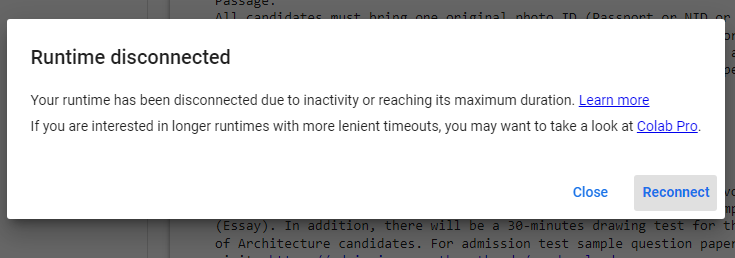) cell for df

In [ ]:
!pip install datasets psutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import Dataset

#Convert dataframe into a hugginface dataset object
dataset = Dataset.from_pandas(df)

#Check the created object
print(dataset)

Dataset({
    features: ['title', 'text'],
    num_rows: 200
})


Next we need to add the passage embeddings.
We have the embeddings as a numpy matrix named embeddings.
Now we need them to be a list of arrays.

In [ ]:
emb_list = []

#For each embedding...
for i in range(embeddings.shape[0]):

        #Add it to the list
        emb_list.append(embeddings[i, :])

Add them with 'add_column' function


In [ ]:
#Add the embeddings to the dataset as a new column.
#This is not done in place

dataset = dataset.add_column("embeddings",emb_list)

#Display the dataset contents
dataset

Dataset({
    features: ['title', 'text', 'embeddings'],
    num_rows: 200
})

Define a new index object and then pass it to the add_faiss_index. 
Then new index will be built.

In [ ]:
index = faiss.IndexHNSWFlat(dim, m , faiss.METRIC_INNER_PRODUCT)

dataset.add_faiss_index(column="embeddings", index_name="embeddings", custom_index = index, faiss_verbose= False)

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['title', 'text', 'embeddings'],
    num_rows: 200
})

Reference dataset ready to feed to RAG

# **RAG Retriever**

Previously we retrieved on our own, but this time we will use the RagRetriever class.

The model is *rag-sequence-nq* 
Model Card can be found [here](https://huggingface.co/facebook/rag-sequence-nq)

Two RAG variants - **RAG-Sequence** and **RAG-Token**.

RAG-Sequence is less compute intensive, but it can't combine information from multiple passages. Instead, for each of the top 'k' passages returned by the Retirever, the Generator produces a separat answer, and then RAG chooses the most probable answer among the 'k' options.

RAG-Token is capable of combining information ('multi-hop'). It generates a single answer to the question. All of the documents. All of the documents are taken into account as we generate each token of this answer.


In [ ]:
from transformers import RagRetriever

retriever = RagRetriever.from_pretrained(
    "facebook/rag-sequence-nq",  #The pre-trained model we using

    use_dummy_datset = False, # Dummy dataset (reduced wikipedia) not needed
    
    indexed_dataset = dataset, #Pass in our dataset

    index_name="embeddings", #Name of the column of FAISS index
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

## **Tokenizer**

Load the tokenzier in order to tokenize our question.

The RagTokeinzer contains multiple tokenizers - 

*   The question tokenzier is accessed with the question_endoder function



In [ ]:
from transformers import RagTokenizer 

tokenizer = RagTokenizer.from_pretrained(
    "facebook/rag-sequence-nq"
)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

## Generator

The Generator is represented by the class RagSequenceForGeneration.
RagTokenGeneration for RAG token variant

We pass the Retriever object to this Generator object

In [ ]:
from transformers import RagSequenceForGeneration

model = RagSequenceForGeneration.from_pretrained(
    'facebook/rag-sequence-nq',
    retriever = retriever
)

Some weights of the model checkpoint at facebook/rag-sequence-nq were not used when initializing RagSequenceForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.weight', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing RagSequenceForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagSequenceForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RagSequenceForGeneration were not initialized from the model checkpoint at facebook/rag-sequence-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to us

## Questions

Here everything is done inside the call to model.generate. This function takes in our question and generates answer.

There are two additional steps.

*   We need to call tokenizer.question_encoder to tokenize the question
*   We call tokenizer.batch_decode at the end to convert the answer tokens back into a printable string.





In [ ]:
import time

t0 = time.time()

question = "How many hours is the admission test?"

#Tokenize the question
input_ids = tokenizer.question_encoder(question, return_tensors='pt')["input_ids"]

#Give the question to RAG 
generated = model.generate(input_ids)

#Convert the answer tokens back into a single string
generated_string = tokenizer.batch_decode(generated, skip_special_tokens=True)[0]

print("Q: " + question)
print("A: " + generated_string)

print('\nResponse took %.2f seconds' % (time.time()-t0))



/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Q: How many hours is the admission test?
A:  two and a half hours

Response took 139.19 seconds


Make a fucntion for all these hard work 😪

In [ ]:
def bolo(question):
  t0 = time.time()

  #Tokenize the question
  input_ids = tokenizer.question_encoder(question, return_tensors='pt')["input_ids"]

  #Give the question to RAG 
  generated = model.generate(input_ids)

  #Convert the answer tokens back into a single string
  generated_string = tokenizer.batch_decode(generated, skip_special_tokens=True)[0]

  print("Q: " + question)
  print("A: " + generated_string)

  print('\nResponse took %.2f seconds' % (time.time()-t0))
  print('\n')
  retrieve(question)
  

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
bolo("How long is the admission exam?")

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Q: How long is the admission exam?
A:  two and a half hours

Response took 160.93 seconds


Index:  100
Similarity Score:  72.23214721679688 

Article Title:  Admission test date instruction 

Passage:
All candidates must bring one original photo ID (Passport or NID or HSC
Registration Card). All candidates must report at least 30 min before the
admission test. Cell phone, digital watch, calculator, tab, camera and hand bag
will not be allowed in the exam hall. All candidates should bring pens, pencils,
sharpeners, erasers etc

Index:  99
Similarity Score:  71.05757141113281 

Article Title:  Required Documents for admission 

Passage:
(a) SSC/O-levels mark sheet and certificate (b) HSC/A-levels mark sheet and
certificate (c) Two recent passport size photographs of candidate and parents
(d) Candidate's Photo and parent's NID/Passport

Index:  68
Similarity Score:  69.94081115722656 

Article Title:  Undergraduate online admission process 

Passage:
Print your admit card Print your admi

bolo(" ")